In [1]:
import tensorflow as tf

import numpy as np
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam,SGD

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
gen=ImageDataGenerator(rotation_range=15,
                      width_shift_range=0.3,
                      height_shift_range=0.1,
                      rescale=1./255)

In [3]:
data_path = './data/flower_photos/'
batch_size = 2313

In [4]:
data_gen = gen.flow_from_directory(directory=data_path,
                                  batch_size=batch_size,
                                  shuffle=True,
                                  target_size=(320,320),
                                  class_mode='categorical')
img, label = data_gen.next()
print(len(img))

Found 2313 images belonging to 5 classes.
2313


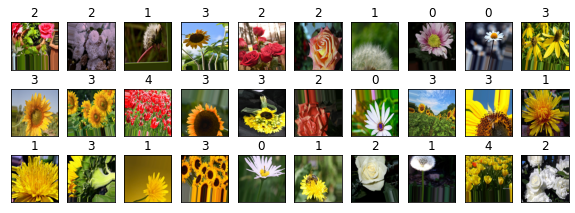

In [5]:
plt.figure(figsize=(10,12))
for i in range(30):
    plt.subplot(10,10, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.title(str(np.argmax(label[i])))
    plt.imshow(img[i])

In [6]:
result = []
for i in range(2313):
    result.append(np.argmax(label[i]))
result = np.array(result).reshape(-1, 1)
result.shape

(2313, 1)

In [7]:
#train_data, test_data split
from sklearn.model_selection import train_test_split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(img, result,test_size=0.3,
shuffle=False, random_state=1004)

In [10]:
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)

x_train shape: (1619, 320, 320, 3)
x_test shape: (694, 320, 320, 3)
y_train shape: (1619, 1)
y_test shape: (694, 1)


In [11]:
#보강할 학습데이터 이미지 생성
augment_ratio = 1.5 #전체 데이터의 150%
augment_size = int(augment_ratio * x_train.shape[0])
print(augment_size)

2428


In [12]:
#전체 x_train 개수의 150%비율만큼
randidx = np.random.randint(x_train.shape[0],size=augment_size)

In [13]:
#임의로 선택된 데이터는 원본데이터를 참조하기 때문에
#원본 데이터에 영향을 줄 수 있음. 그래서 copy() 함수를 통해 안정하게 복사본을 만든다.
x_augmented = x_train[randidx].copy()
y_augmented = y_train[randidx].copy()
print(x_augmented.shape, y_augmented.shape)

(2428, 320, 320, 3) (2428, 1)


In [14]:
#이미지 보강 실행
x_augmented, y_augmented = gen.flow(x_augmented,y_augmented,
                                    batch_size=augment_size,
                                    shuffle=False).next()

print(x_augmented.shape, y_augmented.shape)

(2428, 320, 320, 3) (2428, 1)


In [15]:
# x_train, y_train보강된 데이터 추가(튜플)
x_train=np.concatenate( (x_train, x_augmented) )
y_train=np.concatenate( (y_train, y_augmented) )

print(x_train.shape, y_train.shape)

(4047, 320, 320, 3) (4047, 1)


In [17]:
cnn=Sequential()
cnn.add(Conv2D(32, (3,3), padding='same',activation='relu', input_shape=(32,32,3)))
cnn.add(Conv2D(kernel_size=(3,3), filters=32, padding='same',activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))
# 단 쌓기 단쌓으면 이미지가 줄어서 줄지 않도록 만들기 (패딩넣기)
# 단 쌓아서 정확도가 올라갔다.
cnn.add(Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'))
cnn.add(Conv2D(kernel_size=(3,3), filters=64, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.3))

cnn.add(Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'))
cnn.add(Conv2D(kernel_size=(3,3), filters=128, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

cnn.add(Conv2D(kernel_size=(3,3), filters=256, padding='same', activation='relu'))
cnn.add(MaxPool2D(pool_size=(2,2)))
cnn.add(Dropout(0.25))

# 완전연결성 평탄화
cnn.add(Flatten())

cnn.add(Dense(128, activation='relu'))
cnn.add(Dropout(0.5))
#출력 10 (10가지중에 하나)
cnn.add(Dense(10, activation='softmax'))

cnn.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 conv2d_3 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 32)        0         
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 64)        18496     
                                                                 
 conv2d_5 (Conv2D)           (None, 16, 16, 64)        36928     
                                                      